In [1]:
# This Random Forest Implementation is based off of: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

In [2]:
#We get all dependencis we need for a Random Forest
#If you need a module do: "!pip install [module_name]""
import numpy as np
import pandas as pd
import secrets
import matplotlib.pylab as plt
import itertools
import pickle
import itertools
import pydot

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from collections import Counter
from subprocess import call
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

In [3]:
# Get our `labelled` table as df - This is going to be our training set
# Note that we are removing a URL because we will use that URL for testing

db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df_0s = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight=0 LIMIT 10000', con=db_conn)
df_1s = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight=1', con=db_conn)
df_test = pd.read_sql('SELECT `pitch`, `amplitude`, `subjectivity`, `polarity`, `pred_excitement`, `isHighlight` FROM labelled WHERE isHighlight IS NOT NULL AND url="https://www.youtube.com/watch?v=-5NzaAt_wY0"', con=db_conn)
db_conn.dispose()

df = df_0s.append(df_1s)
print('Number of Rows:', len(df.index))
df.to_csv("data_export.csv", header=True)
df.head()


Number of Rows: 12926


,pitch,amplitude,subjectivity,polarity,pred_excitement,isHighlight
0,49.9597,0.000801,0.000000,0.000000,0,0
1,58.7970,0.000655,0.000000,0.000000,1,0
2,61.5320,-0.000205,0.000000,0.000000,1,0
3,59.4878,0.000786,0.026786,-0.008929,1,0
4,59.9587,-0.000265,0.000000,0.000000,1,0


In [4]:
# Set the training and testing models (for the one URL option)
#X_train = df[['pitch', 'amplitude', 'subjectivity', 'polarity']]
#y_train = df[['isHighlight']]
#X_test = df_test[['pitch', 'amplitude', 'subjectivity', 'polarity']]
#y_test = df_test[['isHighlight']]

In [5]:
# Extract the labels
labels = np.array(df.pop('isHighlight'))
# Set random seed to ensure reproducible runs
RSEED = 50

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.3, random_state = RSEED, shuffle=True)

In [6]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=50, 
                               random_state=RSEED, 
                               max_features = 'auto',
                               n_jobs=-1, verbose = 1)

In [7]:
# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [8]:
# We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 2713
Average maximum depth 37


In [9]:
# Predictions and prediction probabilities on training set
train_predictions = model.predict(X_train)
train_probs = model.predict_proba(X_train)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [10]:
# Predictions and prediction probabilities on testing set
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [11]:
# Print ROC Scores 
# More ROC Curves/Scores: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

# Print Baseline ROC Scores
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9999975202875404
Test ROC AUC  Score: 0.794960173655577
Baseline ROC AUC: 0.5


In [12]:
# Count of Highlight/Non-Highlight probabilities and predictions
print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 707, 0.02: 379, 0.04: 264, 0.06: 211, 0.08: 187, 0.12: 143, 0.1: 130, 0.16: 119, 0.14: 100, 0.18: 93, 0.2: 80, 0.3: 73, 0.22: 72, 0.32: 71, 0.24: 66, 0.38: 59, 0.36: 56, 0.34: 53, 0.26: 52, 0.54: 49, 0.4: 48, 0.44: 44, 0.28: 43, 0.56: 42, 0.48: 39, 0.5: 39, 0.46: 39, 0.62: 37, 0.52: 37, 0.58: 36, 0.64: 35, 0.6: 35, 0.7: 34, 0.72: 33, 0.42: 32, 0.88: 27, 0.68: 27, 0.92: 27, 0.66: 26, 0.74: 26, 0.78: 26, 0.82: 25, 0.84: 25, 0.76: 24, 0.8: 23, 0.86: 22, 0.94: 16, 0.9: 15, 1.0: 14, 0.96: 11, 0.98: 7})
Counter({0: 3199, 1: 679})


In [13]:
# This function is used to evaluate our Random Forest models:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.45 Train: 1.0
Precision Baseline: 0.23 Test: 0.58 Train: 1.0
Roc Baseline: 0.5 Test: 0.79 Train: 1.0


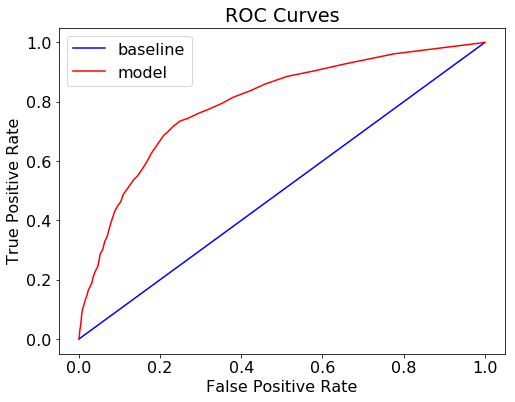

In [14]:
# Random Forest evaluation
evaluate_model(predictions, probs, train_predictions, train_probs)

In [15]:
# This function outputs a confusion matrix for us
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[2712  284]
 [ 487  395]]


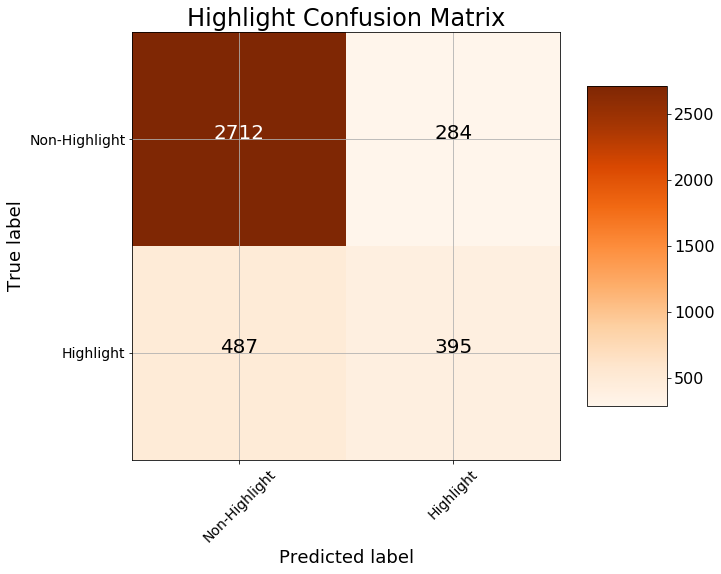

In [16]:
# Output Confusion Matrix given function above
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

In [17]:
# We see feature importance the Random Forest is presenting;
features = list(X_train.columns)

fi = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
1,amplitude,0.364520
0,pitch,0.339702
4,pred_excitement,0.160466
2,subjectivity,0.071308
3,polarity,0.064004


In [18]:
# Optimization of paramaters to see if the model can perform better
# This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [19]:
# Get the best parameters
rs.best_params_

{'n_estimators': 188,
 'min_samples_split': 2,
 'max_leaf_nodes': 33,
 'max_features': 0.7999999999999999,
 'max_depth': 12,
 'bootstrap': True}

In [20]:
# Now we can take the best model (it has already been trained) and evaluate it.
best_model = rs.best_estimator_

In [21]:
train_new_predictions = best_model.predict(X_train)
train_new_probs = best_model.predict_proba(X_train)[:, 1]

new_predictions = best_model.predict(X_test)
new_probs = best_model.predict_proba(X_test)[:, 1]

In [22]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 65
Average maximum depth 9


Recall Baseline: 1.0 Test: 0.38 Train: 0.4
Precision Baseline: 0.23 Test: 0.67 Train: 0.71
Roc Baseline: 0.5 Test: 0.83 Train: 0.85


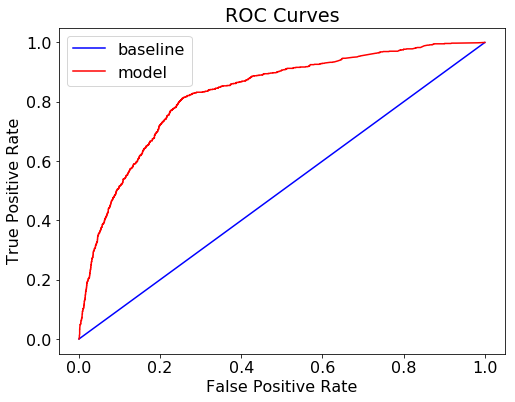

In [23]:
# Random Forest evaluation of optimized model
evaluate_model(new_predictions, new_probs, train_new_predictions, train_new_probs)

Confusion matrix, without normalization
[[2829  167]
 [ 550  332]]


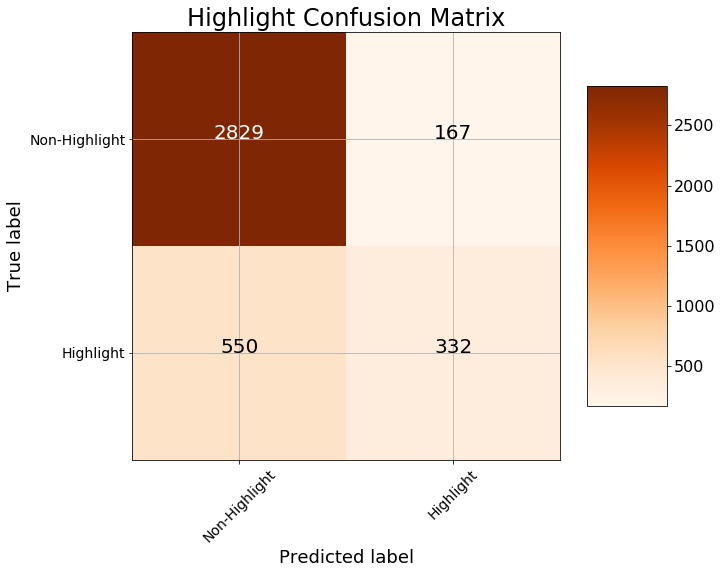

In [24]:
# Output Confusion Matrix given function above
cm = confusion_matrix(y_test, new_predictions)
plot_confusion_matrix(cm, classes = ['Non-Highlight', 'Highlight'],
                      title = 'Highlight Confusion Matrix')

In [25]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=X_train.columns, max_depth = 12, 
                class_names = ['highlight', 'non-highlight'], filled = True)

In [26]:
# Save dot file as image
(graph,) = pydot.graph_from_dot_file('tree_from_optimized_forest.dot')

graph.write_png('tree_from_optimized_forest.png')

In [27]:
# Save the model to disk
filename = 'rf_100t.sav'
pickle.dump(model, open(filename, 'wb'))